# Lab 1

### Lab Date: Wednesday, January 29

### Due: Wednesday, February 5

## Instructions

Work with your lab group to complete the following notebook. It will be reviewed by your peers in lab next week (Wednesday, February 5th). 

This notebook is only lightly scaffolded. This is intentional - as the learning goal for today's lab is as much about how to frame prior fitting and model evaluation as is it the necessary computation. As such, I have left the two major questions at the end of the lab open. If your group is stuck and unsure how to proceed, ask the instructor during lab, come into OH, or, review Chapter 6. Many of the ideas in Chapter 6 are essentially standard statistical practice, wrapped around a Bayesian pipeline, so can be discovered independently without much technical course knowledge. This lab is designed to give you enough space to discover some of these ideas if you would like.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

In [78]:
# Basic Set Up
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy import io, integrate, linalg, signal
import pandas as pd
from scipy.stats import beta
# import pymc as pm
# import bambi as bmb
# import arviz as az
import statsmodels.api as sm

# Add what you like beneath here...

In [79]:
# Load Data for the Lab
success_counts = pd.read_csv('Beta_Binomial_Draws',header=None) # The first column is the number of trials, the second is the number of successes
success_string = pd.read_csv('Ys',header=None) # The specific outcome string (sequence of 0, 1's) for the 100th trial
true_probabilities = pd.read_csv('Thetas_true',header=None) # The true outcome probabilities for each row. DO NOT LOOK AT THIS UNTIL THE END. It is "unknown" and in most problems, unknowable.

In [80]:
success_counts.head()

,0,1
0,78,53
1,58,41
2,59,44
3,49,37
4,24,20


## The (Beta, Binomial) Model

As in class, and as in Chapter 2.4, consider the (Beta, Binomial) model. That is, we draw a success probability $\Theta$ from a Beta distribution with parameters $\alpha, \beta$, then draw $S$ successes from a binomial distribution on $n$ trials, with success probability $\Theta$:

$$ \Theta \sim \text{Beta}(\alpha,\beta), \quad S \sim \text{Binomial}(n,\Theta)$$

We will assume, as usual, that $n$ is known, $S$ is observed, and all other variables are unknown.

It will be our goal in this lab to practice building posterior distributions, and posterior estimates to the unknown success probabilities. We learned how to do this in class for any fixed $\alpha, \beta$. Your main goal for this lab is to learn how to reasonably estimate your prior parameters (note, I did not give them to you), and to check that your prior model leads to sensible posterior inference (model checking). 

## Explore the Data

### The Observables

The file loaded into `success_counts` contains 100 independent draws from this model, for varying $n$. The first column contains the number of trials, the second contains the number of success.

The file loaded into `success_string` contains the actual sequence of outcomes for the 100th trial.

### The Unknown

The file loaded into `true_probabilities` contains the true probabilities $\{\Theta_i\}_{i=1}^100$ for the 100 draws from the full joint model on $(\Theta, S)$. Do not look at this until the end, or unless you are absolutely out of ideas. I have made it available here so that, after choosing your inferential methods, and evaluation scheme, you can go back and check whether we got close to the truth. You should avoid looking at this since in essentially any real Bayesian setting, this would never be known. It is common when testing pipelines to generate and save the truth, as we have done here, to validate that the pipeline is accurate had you known the truth. We'll save this evaluation for the end. For most of the lab, operate under the assumption that this file is inaccessible.

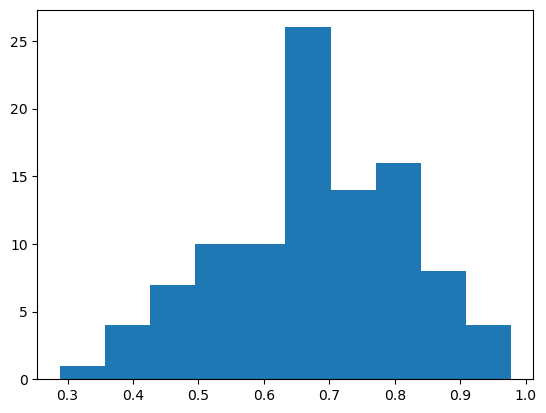

In [81]:
# Use this cell to explore the observable data. Make whatever simple EDA plots you think you need to get some feel for it

success_counts['Fraction'] = success_counts[1]/success_counts[0]
plt.hist(success_counts['Fraction'])
plt.show()


In [82]:
scipy.stats.mode(success_counts['Fraction'])

ModeResult(mode=0.9, count=3)

## The Inferential Pipeline

In class we discussed how to derive the posterior distribution for a model with a Beta prior and a Binomial likelihood. In particular, since the models are conjugate, the posterior is also a Beta distribution. In particular:

$$\Theta|S = s ; n, \alpha, \beta \sim \text{Beta}(s + \alpha, n - s + \beta)$$

In [103]:
#  Estimate alpha and beta for prior using Var(X) and E(X) of observed data:

def calc_a(beta_mean, beta_var):
    return ((beta_mean * (1 - beta_mean))/beta_var) - beta_mean
    
def calc_b(alpha, beta_mean):
   return (alpha * (1 - beta_mean))/beta_mean

beta_mean = np.mean(success_counts['Fraction'][:-1])
beta_var = np.var(success_counts['Fraction'][:-1])

a = calc_a(beta_mean, beta_var)
b = calc_b(a, beta_mean)

In [105]:
print(a)
print(b)

9.871131207054521
4.729053630530463



### Your aim:

We want to estimate $\Theta_{100}$ from $n_{100}$ and $S_{100}$. The other 99 draws from the joint model have been provided for your use either as prior data (note that $\alpha, \beta$ are the same for all 100 draws), or for model checking.

**In the cell below:** write a function that accepts $s, n, \alpha, \beta$ and returns the following posterior summaries:
1. The MLE estimator: $\hat{\theta}_{\text{MLE}}(s;n,\alpha,\beta)$
1. The posterior mean: $\hat{\theta}_{\text{mean}}(s;n,\alpha,\beta)$
1. The posterior mode: $\hat{\theta}_{\text{MAP}}(s;n,\alpha,\beta)$
1. The posterior standard deviation: $\text{SD}[\Theta|S=s]$
1. A basic interval estimate for $\Theta|S=s$ using posterior summaries (1. - 3.). Choose your interval estimate so that it should contain the truth with reasonably high probability. You may decide as a group what convention to use here (a Chebyshev bound, the normal approximation to the Beta, etc.).

In [204]:
def calc_mle(s, n):
    return s/n

def calc_post_mean(s, n, a, b):
    return (a + s)/(a + b + n)

def calc_post_map(s, n, a, b):
    return  (a + s - 1)/(a + b + n - 2)

def calc_post_sd(s, n, a, b):
    post_mean = calc_post_mean(s, n, a, b)
    return np.sqrt((post_mean * (1 - post_mean))/(a + b + n + 1))

# ???

# def calc_post_interval(post_summary, post_sd):
#     upper_interval = post_summary + 1.96 * post_sd
#     lower_interval = post_summary - 1.96 * post_sd
#     return lower_interval, upper_interval

**In the cell below:** write a function that accepts $s, n, \alpha, \beta$ and returns $m$ i.i.d. samples from the posterior distribution:

In [94]:
def get_post_params(s, n, a, b):
    s0 = a
    n0 = b + a
    a_star = s + s0 + 1
    b_star = n + n0 - (s + s0) + 1
    return a_star, b_star

def sample_post(a_star, b_star, m):
    return np.random.beta(a_star, b_star, size=m)

**In the space below:** write a code that accepts $$s,n,\alpha,\beta$$, a chosen number of posterior samples $m$, and a coverage probability $p$. Your code should return:
1. Returns a plot of the posterior density overlaid on a histogram of the $m$ samples
1. Print an interval estimate for $\Theta|S=s$ that contains the unknown with probability $p$. Your interval may be estimated from samples (as is usually done for more complex models), or, as the Beta CDF is easy to work out analytically, from exact quantiles. 

In [141]:
def calc_cred_interval(a, b, p):
    upper_interval = beta.ppf((1 - p/2), a, b)
    lower_interval = beta.ppf(p/2, a, b)
    return lower_interval, upper_interval
    
def plot_post_summary(a, b, m, p):
    
    samples = sample_post(a, b, m)
    x = np.linspace(0, 1, 1000)
    pdf_values = scipy.stats.beta.pdf(x, a, b)
    lower_interval, upper_interval = calc_cred_interval(a, b, p)

    plt.hist(samples, density=True)
    plt.plot(x, pdf_values, color='red')
    plt.axvline(x=lower_interval, color='green', linestyle='--', label=f'Lower credible interval ({lower_interval:.3f})')
    plt.axvline(x=upper_interval, color='green', linestyle='--', label=f'Upper credible interval ({upper_interval:.3f})')
    plt.legend()

**In the space below:** Apply the codes you wrote above to explore the range of different posterior distributions for $\Theta_{100}|S_{100} = s_{100}$ that can be produced by varying the prior parameters $\alpha$ and $\beta$. I am not going to give you specific prior parameter pairs to check here. Instead, be responsible for your own exploration. Stop once you think you have sufficiently demonstrated the possible posteriors, and their dependence on the possible prior assumptions.

*Note: For this sort of demonstration, it helps to do a little back of the envelope thinking first about how the prior parameters bias the posterior, and the balance of information provided by the prior and by the data collected.*

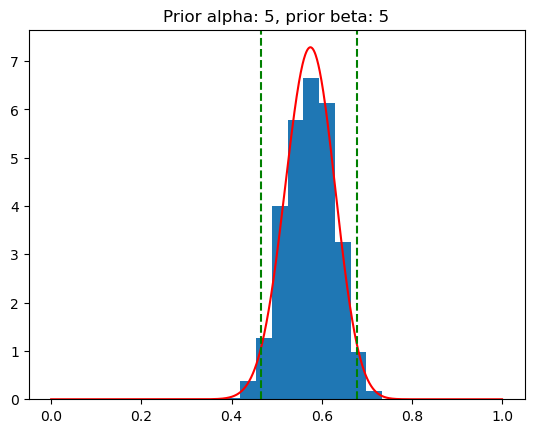

MLE: 0.586, mean: 0.579, MAP: 0.580


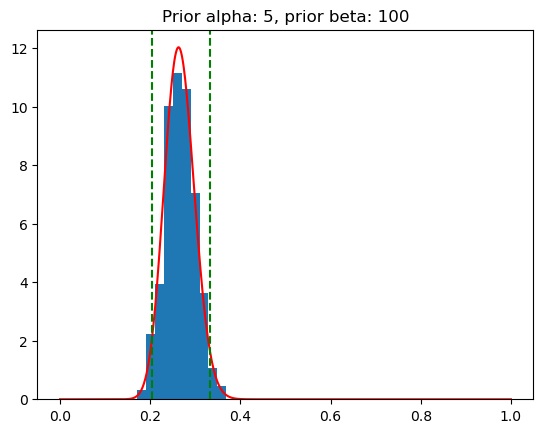

MLE: 0.586, mean: 0.356, MAP: 0.355


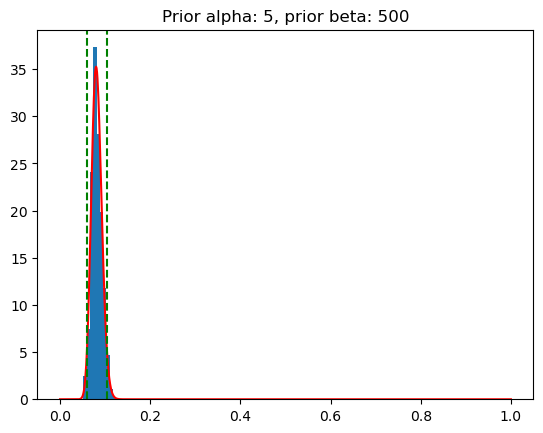

MLE: 0.586, mean: 0.136, MAP: 0.135


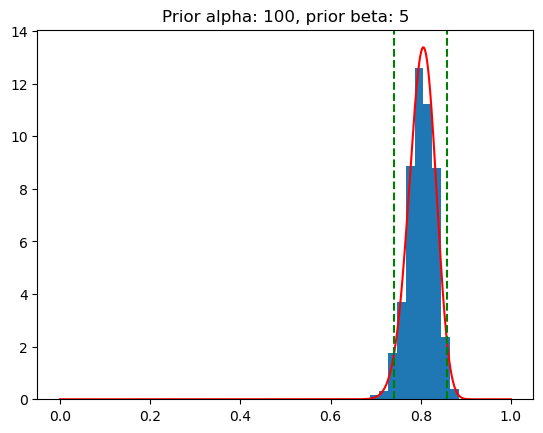

MLE: 0.586, mean: 0.741, MAP: 0.743


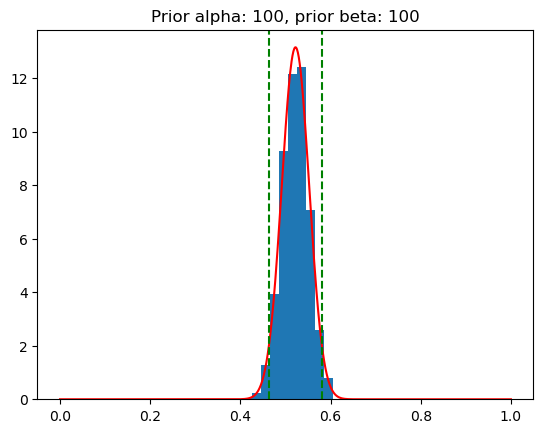

MLE: 0.586, mean: 0.535, MAP: 0.535


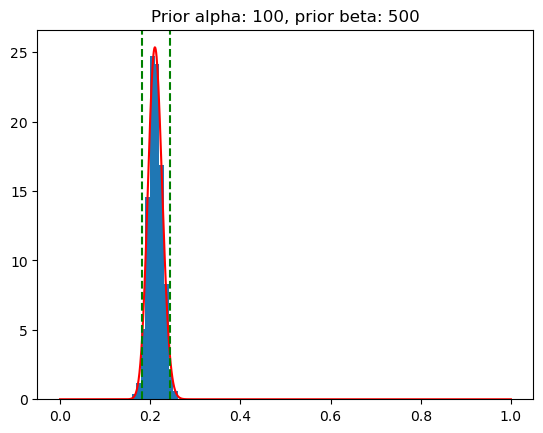

MLE: 0.586, mean: 0.247, MAP: 0.246


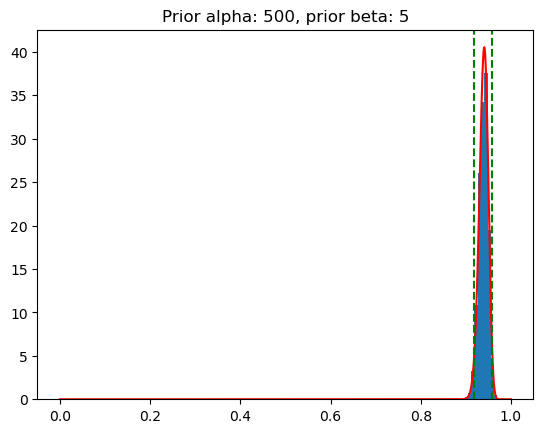

MLE: 0.586, mean: 0.901, MAP: 0.902


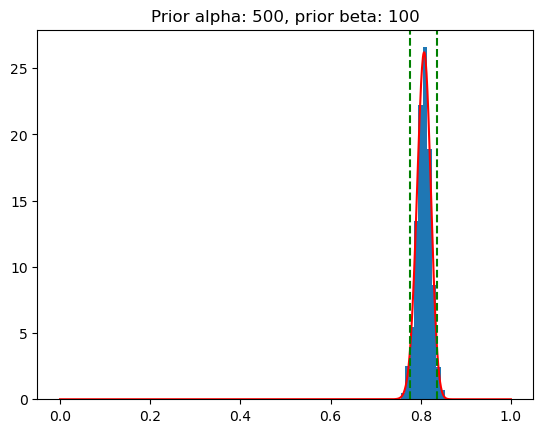

MLE: 0.586, mean: 0.786, MAP: 0.786


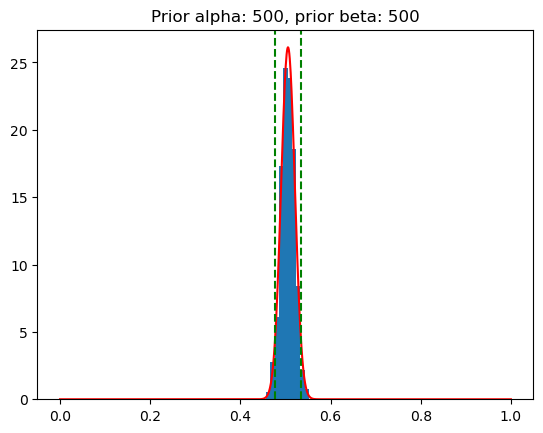

MLE: 0.586, mean: 0.511, MAP: 0.511


In [208]:
p = .05
m = 1000
s = success_counts[1].tolist()[-1]
n = success_counts[0].tolist()[-1]
mle = calc_mle(s, n)

alphas = [5, 100, 500]
betas = [5, 100, 500]

for alpha in alphas:
    for beta_param in betas:
        a_star, b_star = get_post_params(s, n, alpha, beta_param)
        post_mean = calc_post_mean(s, n, a_star, b_star)
        post_map = calc_post_map(s, n, a_star, b_star)
        plot_post_summary(a_star, b_star, m, p)
        plt.title(f'Prior alpha: {alpha}, prior beta: {beta_param}')
        plt.show()
        
        print(f"MLE: {mle:.3f}, mean: {post_mean:.3f}, MAP: {post_map:.3f}")

## Gathering Information

In Bayesian statistics, observations provide information via conditioning. Let's see how our posterior changes sequentially as we gain evidence.

**In the cell below:** Write a code that walks through the `success_string` corresponding to the 100th trial. As it goes, use the code you wrote above to print out a sequence of plots and interval estimates for the unknown. For now, initialize the process with a uniform prior ($\alpha = 1, \beta = 1$). What do you notice about the posterior (its shape, its uncertainty with respect to resampling, etc) as we gather evidence? What do you notice about its point summaries (the MLE, MAP, and posterior mode)?

*Note: you don't need a unique output for all 70 trials in the success string. Instead, space your outputs to show the main trends. You should space your outputs tighter at the beginning, when our posterior is more sensitive to any individual trial outcome, and less tightly at the end. As a basic heuristic, the spacing should grow quadratically.*

If you feel you already have a decent intuition for the Beta distribution, I would save this step for the end of the lab. If you'd like to try a basic widget to see how the shape of the Beta depends on its parameters, go to [this article](https://www.mathmouth.com/bayesball) and scroll to Demo 3 (roughly 3/5ths of the way down).

In [219]:
num_intervals = 10
start = 0
rows = []

for n in range(1, num_intervals + 1):
    end = start + n**2
    rows.append(end)

In [220]:
rows = [row for row in rows if row < success_string.shape[0]]

In [ ]:
a = 1
b = 1

for trial in rows:
    s = success_string[0].iloc[:trial].sum()
    n = trial
    a_star, b_star = get_post_params(s, n, a, b)
    plot_post_summary(a_star, b_star, m, p)
    print(f"Trail #:{trial}")
    plt.title(f'Posterior alpha: {a_star}, posterior beta: {b_star}')
    plt.show()

## Fitting the Prior

You should have seen that, your estimates above depend on your choice of prior parameters. This is the point of Bayesian inference. The prior *should* influence our estimation.

In order to influence our estimates informatively, the prior must encode actual information. Otherwise, the Bayesian pipeline is really just a different estimation procedure that uses the mathematics of conditioning to define intervals and to regularize the inference.

Discuss with your group how you could use the first 99 sample outcomes to estimate $\alpha$ and $\beta$. 

*For now, we will assume that the form of the prior model (i.e. the Beta) is correct. We will discuss what happens if your prior form is misspecified (does not contain the true data generating distribution for any parameter values) later in the class. I generated this data using the model specified above.*

If you get stuck, consider the following pair of ideas:
1. You could, select a set of previous observations with large $n_j$, estimate $\theta_j$ for each with a simple point estimator, then fit the resulting ensemble of estimated $\theta$'s to a Beta distribution (either by matching moments or via an MLE). *If you choose this route, discuss the trade-off between using many past samples, and incorporating less reliable past samples*
1. Consider the marginal distribution of $S$ drawn from the joint model $(\Theta, S)$. When evaluated at $S = s$ we called this the "evidence". Discuss the relationship between the marginal distribution of $\{S_j\}_{j=1}^{99}$ and the prior parameters. Does this relation have a familiar name? Could you use it to estimate $\alpha$ and $\beta$? If so, what standard framework could you adopt?

How you proceed from here is up to you. Note: if you choose 1., you will have to explain how you fit (i.e. how to solve the moment matching problem). If you choose 2, I strongly suggest you look ahead to the first part of the last section of the lab.

Comment on your degree of confidence in your prior parameter fits. Think about simple procedures for evaluating your uncertainty in the prior parameter fits with your group. Based on your experience toying with the posterior for different prior choices, do you believe you've resolved the parameters with enough confidence so that your posterior is reliable (i.e. the uncertainty captured in the posterior fully captures your uncertainty about the unknown)?

*Replace this text with your discussion. You are welcome to attempt the procedure you sketch out below.*

## Model Checking

### The Evidence

Derive the marginal distribution for the number of observed successes $S$ given $(\Theta,S)$ drawn with parameters $\alpha, \beta, n$. That is, derive an explicit formula for $\text{Pr}(S = s)$ for all $s \in \{1,2,...,n\}$. You may express your answer using any standard combinatorial functions (factorial, choose, $\Gamma$, Beta, etc). Do not try to close the integrals directly. Instead, reference the normalization factor used in the Beta distribution's density function.

*Replace this text with your analysis*

Give an argument justifying the word "evidence" to describe $\text{Pr}(S = s)$. Relate your answer to the likelihood function of the \textit{prior} parameters $\alpha, \beta$.

*Replace this text with your discussion*

### Posterior Predictive Distribution

Use your work above, and the rule that updates the prior (produces the posterior), given an observation, to derive the posterior predictive distribution for a new set of $m$ sample outcomes, given an observed set of $n$ outcomes containing $s$ successes.

*Replace this text with your analysis*

With your group, discuss how you could use this distribution to check whether your model (and, deductively, your inferences regarding the unknown) are realistic given your observations.

Hint:
1. It may help to first think about trying to evaluate the probability of observing what you observed, conditioned on what you observed. This will motivate the need for the word "prediction", and the distinction between evaluating a likelihood, evaluating the evidence, and predictive checking.
1. Since we only have access to a fixed data set, consider breaking your data set into pieces that serve separate purposes. Just as we secluded a prior data set ($j = 1, 99$), we could further split the data to include an evaluation or test set. Discuss how you might compare posterior predictions to this test set, whether it would make sense to evaluate the posterior predictive probability of observing the test set, and what does or doesn't go wrong if you tried to evaluate the posterior predictive probability of observing the data *that you did observe (i.e. conditioned on).*

If you start going in circles here, call over the instructor, or review BDA chapter 6.

*Replace this text with your discussion. Then, describe your method, and implement an example below.*

## Post-Script (Peaking at the Answer)

*This part is optional.*

Now that you have a pipeline for: a. fitting the prior, b. using it to produce inferences, and c. rejecting models that produce implausible inferences, it's worth seeing whether that pipeline typically returns accurate inferences. 

Select a subset of the provided data as a prior set for fitting the prior parameters, then apply steps b and c to the remaining test cases. Think carefully about whether you should use step c to eliminate specific test cases, or to eliminate all inferences if enough test cases are sufficiently implausible. Then, compare your remaining answers to the true success probabilities.

Note: A nice way to summarize whether your pipeline is producing accurate answers when you have access to the truth is via a coverage test. That is, return an interval estimate for each unknown $\Theta_j$ in the test set that should hold the unknown with some large success probability (I usually repeat this for success probabilities 0.5, 0.75, 0.875, 0.95, 0.99 or something to the effect). Then, compute the fraction of the intervals that *actually* contained the truth. These should match. Notice that this is essentially a procedural guarantee. Consider the analogy to confidence intervals. This process of checking whether the pipeline produces intervals that actually cover the unknown as often as they purport to cover the unknown is especially important in more complicated examples when we can't perform step b exactly, and instead use approximations to perform posterior inference.